In [27]:
from itertools import cycle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io.arff import loadarff 

#Funções de avaliação dos modelos
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    multilabel_confusion_matrix,
    plot_roc_curve,
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    roc_auc_score,
)
from sklearn.model_selection import(
    train_test_split, 
    cross_val_predict,
    KFold,
    GridSearchCV,
)

from sklearn.preprocessing import label_binarize

#utils
from utils.num import Num

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC

In [4]:
# loading data
raw_data = loadarff('mnist_784.arff')
df = pd.DataFrame(raw_data[0])

In [5]:
# treino e teste
X = df.iloc[:, 0:-1]
y = df.iloc[:, [-1]].astype('int') # target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=199)

In [6]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_val)
y_score = dt.predict_proba(X_val)

In [36]:
y_score

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [24]:
confusion_matrix(y_val, y_pred)

array([[660,   1,   9,   2,   2,   8,   9,   1,  11,   4],
       [  0, 756,   5,   5,   4,   3,   2,   5,   5,   2],
       [  6,   7, 602,  13,  16,   2,  13,  11,  21,   6],
       [  7,   7,  20, 596,   7,  28,   5,  15,  14,  15],
       [  2,   7,  10,   4, 600,   6,   8,   8,  11,  41],
       [ 10,   9,   7,  27,  12, 534,  17,   6,  19,  11],
       [ 10,   4,   5,   2,  13,  14, 675,   1,  17,   4],
       [  2,   2,  12,   4,  10,   1,   0, 629,   5,  19],
       [  4,  10,  26,  17,  12,  12,  10,   5, 542,  22],
       [  2,   3,   4,  13,  31,  21,   1,  26,  14, 542]])

In [25]:
# Compute ROC curve and ROC area for each class
classes = [i for i in range(10)]
n_classes = len(classes)
y_bin = label_binarize(y_val, classes=classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

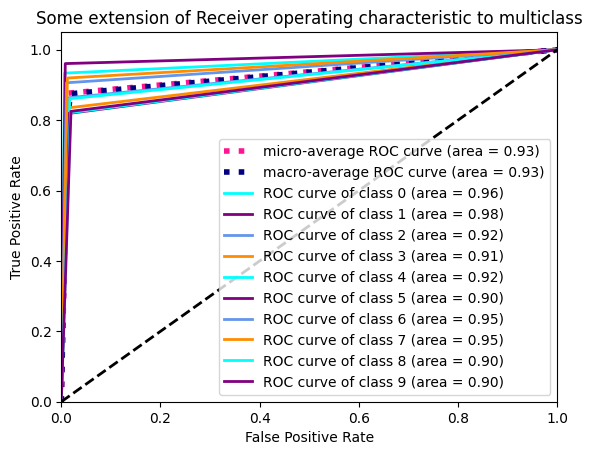

In [34]:
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "purple", "cornflowerblue", "darkorange"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()